<a href="https://colab.research.google.com/github/myselfdk03/heat-equation-using-PINNs/blob/main/PINNs_for_Heat_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Heat Transfer Model

The heat equation describes how heat diffuses through a medium over time. It is a parabolic partial differential equation (PDE) given by:

\begin{equation}
    \frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
\end{equation}

where:

1.   $u(x,t)$ is the temperature at position $x$ and time $t $.
2.   $\alpha$ is the thermal diffusivity of the material.
3. $ \frac{\partial u}{\partial t}$ represents the rate of change of temperature over time.
4.  $\frac{\partial^2 u}{\partial x^2} $ represents the diffusion of heat in space.

This equation models heat conduction in a one-dimensional rod where heat spreads over time.

In [48]:
# import required library
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [49]:
# assigning parameters
xmin, xmax = 0,1
ymin, ymax = 0,1

layers = [2, 30, 30, 30, 1]
lr = 0.01
epochs = 5000
N_train = 100 # number of points
N_test = 100 # testing points

In [50]:
# define physics loss
def physics_loss(model, x,t):
  with tf.GradientTape(persistent = True) as tape2:
    tape2.watch(x)
    tape2.watch(t)
    with tf.GradientTape(persistent = True) as tape1:
      tape1.watch(x)
      tape1.watch(t)
      u = model(tf.concat([x,t], axis = 1))
    du_dx = tape1.gradient(u,x)
    du_dt = tape1.gradient(u,t)
  du_dxx = tape2.gradient(du_dx, x)
  del tape1, tape2
  residual = tf.reduce_mean(tf.square(du_dt - 0.01 * du_dxx))
  return residual

In [51]:
# define loss on boundary
x_bc = tf.concat([tf.zeros((N_train, 1)), tf.ones((N_train, 1))], axis=0)
t_bc = tf.random.uniform((2 * N_train, 1), minval=0, maxval=1)

x_ic = tf.random.uniform((N_train, 1), minval=0, maxval=1)
t_ic = tf.zeros((N_train, 1))
u_ic = tf.sin(np.pi * x_ic)  # Initial condition u(x,0) = sin(pi*x)

def loss_bc(model):
    xt_bc = tf.stack([x_bc, t_bc], axis=1)
    u_bc = model(xt_bc)
    return tf.reduce_mean(tf.square(u_bc))

# Enforce u(0,t) = u(1,t) = 0
def loss_ic(model):
    xt_ic = tf.stack([x_ic, t_ic], axis=1)
    u_ic_pred = model(xt_ic)
    return tf.reduce_mean(tf.square(u_ic_pred - u_ic))

In [52]:
# define training sequence
def train(model, optimizer, x, t):
  with tf.GradientTape() as tape:
    loss_pde = physics_loss(model, x, t)
    total_loss = loss_pde + loss_bc(model) + loss_ic(model)
  grads = tape.gradient(total_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return total_loss, loss_pde

In [53]:
x_train = tf.random.uniform((N_train,1), xmin, xmax)
t_train = tf.random.uniform((N_train, 1), ymin, ymax)

In [54]:
# define model and train

total_loss_ar = []
pde_loss_ar = []
bound_loss_ar = []

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(2,)),
    *[tf.keras.layers.Dense(layer, activation='tanh') for layer in layers[1:-1]],
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

for epoch in range(epochs):
  total_loss, loss_pde = train(model, optimizer, x_train, t_train)
  total_loss_ar.append(total_loss)
  pde_loss_ar.append(loss_pde)
  if epoch%500 ==0 or epoch == epochs-1:
    print(f'Epoch: {epoch}, Total Loss: {total_loss.numpy()}, PDE Loss: {loss_pde.numpy()}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch: 0, Total Loss: 0.8609951138496399, PDE Loss: 0.2779156267642975
Epoch: 500, Total Loss: 0.00012369221076369286, PDE Loss: 9.83673453447409e-05
Epoch: 1000, Total Loss: 0.003765758126974106, PDE Loss: 0.00013282921281643212
Epoch: 1500, Total Loss: 2.3178308765636757e-05, PDE Loss: 1.9711918866960332e-05
Epoch: 2000, Total Loss: 1.0221096999885049e-05, PDE Loss: 9.24188680073712e-06
Epoch: 2500, Total Loss: 1.177569356514141e-05, PDE Loss: 1.0127275345439557e-05
Epoch: 3000, Total Loss: 3.5435114114079624e-05, PDE Loss: 2.2454883946920745e-05
Epoch: 3500, Total Loss: 6.389766895154025e-06, PDE Loss: 5.701642294297926e-06
Epoch: 4000, Total Loss: 6.377807039825711e-06, PDE Loss: 5.442453129944624e-06
Epoch: 4500, Total Loss: 5.805462569696829e-05, PDE Loss: 1.7642656530370004e-05
Epoch: 4999, Total Loss: 8.281675945909228e-06, PDE Loss: 5.094741482025711e-06


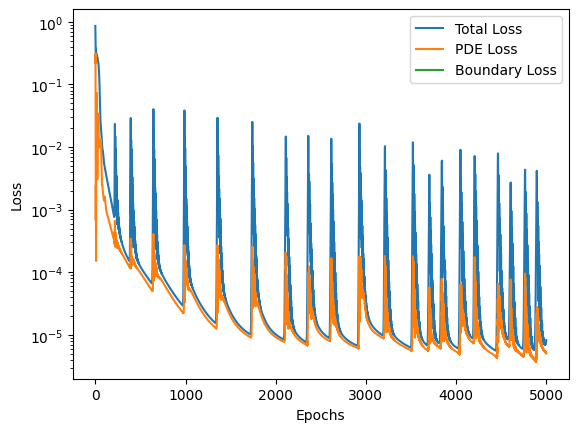

In [55]:
# plotting loss

plt.figure()
plt.yscale('log')
plt.plot(total_loss_ar, label = 'Total Loss')
plt.plot(pde_loss_ar, label = 'PDE Loss')
plt.plot(bound_loss_ar, label = 'Boundary Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
# define exact solution
def exact_solution(points):
    x = tf.expand_dims(points[:,0], axis = 1)
    t = tf.expand_dims(points[:,1], axis = 1)
    solution =  np.exp(-np.pi**2 * 0.01 * t) * np.sin(np.pi * x)
    return solution.reshape((-1,))

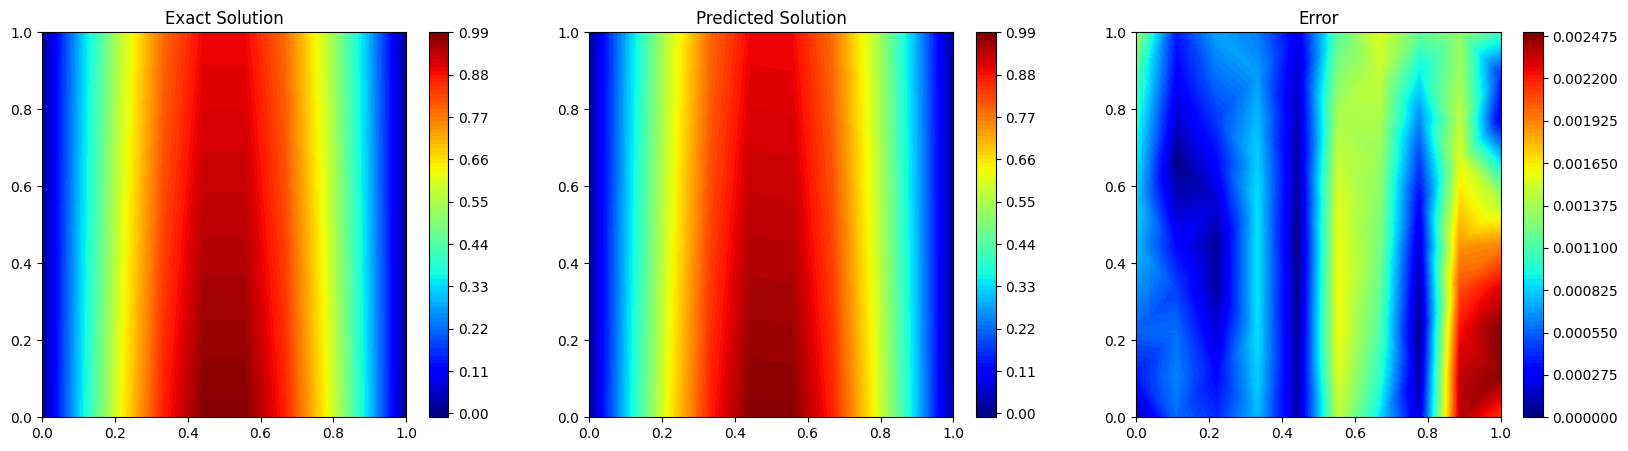

In [57]:
# plot the results
def generate_test_points(xmin, xmax, ymin, ymax, num_points=100):
    num = int(np.sqrt(num_points))
    x_test = np.linspace(xmin, xmax, num)
    y_test = np.linspace(ymin, ymax, num)
    X_test, Y_test = np.meshgrid(x_test, y_test)
    test_pt = np.column_stack((X_test.flatten(), Y_test.flatten()))
    return test_pt

test_pt = generate_test_points(xmin, xmax, ymin, ymax, N_test)
test_pt = tf.convert_to_tensor(test_pt, dtype = tf.float32)
u_test = model(test_pt)
test_pt = test_pt.numpy()
u_test = u_test.numpy()

plt.figure(figsize = (20,5))

plt.subplot(1,3,1)
plt.tricontourf(test_pt[:,0], test_pt[:,1], exact_solution(test_pt), cmap = 'jet', levels = 100)
plt.colorbar()
plt.title('Exact Solution')

plt.subplot(1,3,2)
plt.tricontourf(test_pt[:,0], test_pt[:,1], u_test[:,0], cmap = 'jet', levels = 100)
plt.colorbar()
plt.title('Predicted Solution')

plt.subplot(1,3,3)
plt.tricontourf(test_pt[:,0], test_pt[:,1], abs(u_test[:,0] - exact_solution(test_pt)), cmap = 'jet', levels = 100)
plt.colorbar()
plt.title('Error')
plt.show()
